In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf

import time

# load the data
file_name = '-train-rgbs-new'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-ref/'
file_path = '../data/master-APOGEE-giants-train.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

# define the training set
train_ID = label_data['ids']
train_flux = spectra_data['fluxes']
train_flux_err = spectra_data['fluxes_err']
train_flux_ivar = spectra_data['fluxes_ivars']
train_label = label_data['labels']
train_label_err = label_data['labels_err']
train_label_ivar = label_data['labels_ivars']

../spec/spectra-reference-stars-APOGEE-giants-ref/spectra_data-train-rgbs-new.dat
File already exists. Loading spectra data


24it [00:00, 83.07it/s]

Loaded data successfully


In [2]:
# initialise the noise in the pixels
ln_noise_fluxes_init = jnp.full(train_flux.shape[1], -8.0)

# define a range of l2 regularisation strengths to test
l2_reg_strength = jnp.array([0.1, 1., 10., 100])

# define a range of latent dimensionality to test
P = jnp.array([13, 25, 49, 97]) # this is 1, 2, 4, 8 times size of the labels, M +1; +1 here cause you need the latents dimensionality to be M+1

# define other variables in the model and where to save outputs
iterations = 5
omega = 1. # we will set this to one as we tried varying this and it doesn't do much
k = 5 # 5 k-folds
savepath = '../sav/paper/'+str(k)+'-fold-'

# first run the agenda without noise to optimise the latents quickly using a least-squares solver. Do this for every size of latent dimentionality

In [325]:
# loop over the latent dimensionality
for jndx, j in tqdm.tqdm_notebook(enumerate(P)):
    ids_, lab_data, spec_data, alphas_init, betas_init, zetas_init = kf.split_kfold_data(train_ID, train_label, train_label_err, train_label_ivar, train_flux, train_flux_err, train_flux_ivar, k, j)

    # create empty lists to store values
    alphas_kfold = []
    betas_kfold = []
    zetas_kfold = []
    chi2_iter_kfold = []

    print('Running optimisation of model latents on k-fold samples for a latent dimensionality of '+str(j))
    for hndx, h in enumerate(alphas_init):
        alphas_ = h
        betas_ = betas_init[hndx]
        zetas_ = zetas_init[hndx]


        for lndx, l in enumerate(range(iterations)):

            start_time = time.time()
            
            # run optimisation routine without noise
            alphas_, betas_, zetas_, diff_chi2_iter, chi2_iter = opt.run_agenda(alphas_, betas_, zetas_, lab_data['labels_train'][hndx], lab_data['labels_train_err'][hndx],\
                                                                                            spec_data['fluxes_train'][hndx], spec_data['fluxes_train_err'][hndx], omega)

            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time to run agenda: {elapsed_time:.2f} seconds")

        alphas_kfold.append(alphas_)
        betas_kfold.append(betas_)
        zetas_kfold.append(zetas_)
        chi2_iter_kfold.append(chi2_iter)
        
    
    jnp.save(savepath+'latent_dim_' + str(j)+'-alphas', alphas_kfold)
    jnp.save(savepath+'latent_dim_' + str(j)+'-betas', betas_kfold)
    jnp.save(savepath+'latent_dim_' + str(j)+'-zetas', zetas_kfold)
    jnp.save(savepath+'latent_dim_' + str(j)+'-chi2_iter', chi2_iter_kfold)
    jnp.save(savepath+'label_data', lab_data)
    jnp.save(savepath+'spectral_data', spec_data)


/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_19141/4241305098.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for jndx, j in tqdm.tqdm_notebook(enumerate(P)):


0it [00:00, ?it/s]

# already ran this before

In [25]:
# P = 13
alphas_P13_kfold = jnp.load(savepath+'latent_dim_13-alphas.npy', allow_pickle=True)
betas_P13_kfold = jnp.load(savepath+'latent_dim_13-betas.npy', allow_pickle=True)
zetas_P13_kfold = jnp.load(savepath+'latent_dim_13-zetas.npy', allow_pickle=True)

# P = 25
alphas_P25_kfold = jnp.load(savepath+'latent_dim_25-alphas.npy', allow_pickle=True)
betas_P25_kfold = jnp.load(savepath+'latent_dim_25-betas.npy', allow_pickle=True)
zetas_P25_kfold = jnp.load(savepath+'latent_dim_25-zetas.npy', allow_pickle=True)

# P = 49
alphas_P49_kfold = jnp.load(savepath+'latent_dim_49-alphas.npy', allow_pickle=True)
betas_P49_kfold = jnp.load(savepath+'latent_dim_49-betas.npy', allow_pickle=True)
zetas_P49_kfold = jnp.load(savepath+'latent_dim_49-zetas.npy', allow_pickle=True)

# P = 97
alphas_P97_kfold = jnp.load(savepath+'latent_dim_97-alphas.npy', allow_pickle=True)
betas_P97_kfold = jnp.load(savepath+'latent_dim_97-betas.npy', allow_pickle=True)
zetas_P97_kfold = jnp.load(savepath+'latent_dim_97-zetas.npy', allow_pickle=True)

lab_data = jnp.load(savepath+'label_data.npy', allow_pickle=True)
spec_data = jnp.load(savepath+'spectral_data.npy', allow_pickle=True)

# now run the optimisation routine with noise. Here, we will vary the strength of the L2 regularisation

In [27]:
# stack all the latents
alphas_ = [alphas_P13_kfold, alphas_P25_kfold, alphas_P49_kfold, alphas_P97_kfold]
betas_ = [betas_P13_kfold, betas_P25_kfold, betas_P49_kfold, betas_P97_kfold]
zetas_ = [zetas_P13_kfold, zetas_P25_kfold, zetas_P49_kfold, zetas_P97_kfold]


In [28]:
for jndx, j in enumerate(P):
    ids_, lab_data, spec_data, alphas_init, betas_init, zetas_init = kf.split_kfold_data(train_ID, train_label, train_label_err, train_label_ivar, train_flux, train_flux_err, train_flux_ivar, k, j)

In [6]:
def opt_lnfluxvar_betas_zetas(alphas, betas, zetas,\
                            lab_data, spec_data, ln_noise_fluxes_init, \
                            l2_reg_strength, omega, name='latent_dim_13_L2reg'):

    # loop over every L2 reg strength
    for indx, i in enumerate(l2_reg_strength):
        betas_updated = []
        zetas_updated = []
        ln_noise_fluxes_updated = []
        nll_ = []
        # loop over every k-fold sample
        for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):
            
            # run optimisation routine with noise in the flux
            betas_iter, zetas_iter, ln_noise_fluxes_iter, nll_iter = opt_sc.run_agenda(j, betas[jndx], zetas[jndx], lab_data['labels_train'][jndx],\
                                                        lab_data['labels_train_ivars'][jndx], spec_data['fluxes_train'][jndx], spec_data['fluxes_train_ivars'][jndx],\
                                                        ln_noise_fluxes_init, i, omega)
        
            betas_updated.append(betas_iter)
            zetas_updated.append(zetas_iter)
            ln_noise_fluxes_updated.append(ln_noise_fluxes_iter)
            nll_.append(nll_iter)

        jnp.save(savepath+str(name)+str(i)+'-betas_', betas_updated)
        jnp.save(savepath+str(name)+str(i)+'-zetas_', zetas_updated)
        jnp.save(savepath+str(name)+str(i)+'-ln_noise_fluxes_', ln_noise_fluxes_updated)
        jnp.save(savepath+str(name)+str(i)+'-nll_', nll_)


In [8]:
def opt_lnfluxvar_betas_zetas(alphas, betas, zetas,\
                            lab_data, spec_data, ln_noise_fluxes_init, \
                            l2_reg_strength, omega, name='latent_dim_13_L2reg'):

    betas_updated = []
    zetas_updated = []
    ln_noise_fluxes_updated = []
    nll_ = []
    # loop over every k-fold sample
    for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):
        
        # run optimisation routine with noise in the flux
        betas_iter, zetas_iter, ln_noise_fluxes_iter, nll_iter = opt_sc.run_agenda(j, betas[jndx], zetas[jndx], lab_data['labels_train'][jndx],\
                                                    lab_data['labels_train_ivars'][jndx], spec_data['fluxes_train'][jndx], spec_data['fluxes_train_ivars'][jndx],\
                                                    ln_noise_fluxes_init, l2_reg_strength, omega)
    
        betas_updated.append(betas_iter)
        zetas_updated.append(zetas_iter)
        ln_noise_fluxes_updated.append(ln_noise_fluxes_iter)
        nll_.append(nll_iter)

    jnp.save(savepath+str(name)+str(int(l2_reg_strength))+'-betas_', betas_updated)
    jnp.save(savepath+str(name)+str(int(l2_reg_strength))+'-zetas_', zetas_updated)
    jnp.save(savepath+str(name)+str(int(l2_reg_strength))+'-ln_noise_fluxes_', ln_noise_fluxes_updated)
    jnp.save(savepath+str(name)+str(int(l2_reg_strength))+'-nll_', nll_)


In [9]:
opt_lnfluxvar_betas_zetas(alphas_P13_kfold, betas_P13_kfold, zetas_P13_kfold, lab_data, spec_data, ln_noise_fluxes_init, 1000, omega, name='latent_dim_13_L2reg')

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_27152/1617058487.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 217204944.0495323, Curvature error: 233325572147152.84
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 6137.1705901124315, Curvature error: 6591772803.465353
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 268083124.11750206, Curvature error: 287981980021639.1
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 6307.394018375877, Curvature error: 6774631745.474764
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 203506199.9550989, Curvature error: 218610941276337.6
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 6327.503960610965, Curvature error: 6796246048.690642
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 248059467.28659034, Curvature error: 266466602507799.06
I

In [33]:
opt_lnfluxvar_betas_zetas(alphas_P25_kfold, betas_P25_kfold, zetas_P25_kfold, lab_data, spec_data, ln_noise_fluxes_init, 1000, omega, name='latent_dim_25_L2reg')

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_27152/1617058487.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 91546803.19921723, Curvature error: 98343244892855.64
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 237597.66597164428, Curvature error: 255142347119.38208
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 97222126.93207608, Curvature error: 104443110550859.3
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 255026.43087327445, Curvature error: 273856644326.84644
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 119626904.22478078, Curvature error: 128508186503353.45
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 251350.11397857216, Curvature error: 269909640582.58044
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 131939493.60948603, Curvature error: 141734818408455

In [34]:
opt_lnfluxvar_betas_zetas(alphas_P49_kfold, betas_P49_kfold, zetas_P49_kfold, lab_data, spec_data, ln_noise_fluxes_init, 1000, omega, name='latent_dim_49_L2reg')

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_27152/1617058487.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 84462453.78693587, Curvature error: 90721051315997.73
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 487411.46344774065, Curvature error: 523388647602.8659
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 91682325.80926669, Curvature error: 98475720101941.22
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 530456.9846604418, Curvature error: 569610116587.2947
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 89914169.39108573, Curvature error: 96577751405046.03
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 510527.8611985789, Curvature error: 548211940886.5322


2024-11-28 15:59:19.483013: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 15m15.729872s

********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 106264352.42345546, Curvature error: 114136018898800.6
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 512878.6747378561, Curvature error: 550734970221.6725
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 90852952.96078613, Curvature error: 97585946634430.05
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 515152.28567569004, Curvature error: 553176885682.5309


In [35]:
opt_lnfluxvar_betas_zetas(alphas_P97_kfold, betas_P97_kfold, zetas_P97_kfold, lab_data, spec_data, ln_noise_fluxes_init, 1000, omega, name='latent_dim_97_L2reg')

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_27152/1617058487.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for jndx, j in tqdm.tqdm_notebook(enumerate(alphas)):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 97804130.17665453, Curvature error: 105040547023005.66
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 945218.8078770577, Curvature error: 1014957403949.9899
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 89995054.20696186, Curvature error: 96655538731608.61
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 1011276.2638520638, Curvature error: 1085887896832.0148
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 84156246.7803292, Curvature error: 90385579588822.02
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 1039271.7437237436, Curvature error: 1115948166836.5488
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 89984654.94707505, Curvature error: 96645003889406.25
I

# load in the updated optimised params, then compute the new zetas for the test set, and estimate the model accuracy

In [6]:
# P = 13
#  Omega = 0.1 
latent_dim = '97'
l2strength = '0point1'
loadpath = '../sav/paper/5-fold-latent_dim_'+latent_dim+'_L2reg'+l2strength
betas_omega0_kfold = jnp.load(loadpath+'-betas_.npy', allow_pickle=True)
zetas_omega0_kfold = jnp.load(loadpath+'-zetas_.npy', allow_pickle=True)
noisefluxes_omega0_kfold = jnp.load(loadpath+'-ln_noise_fluxes_.npy', allow_pickle=True)

# Omega = 1 
l2strength = '1'
loadpath = '../sav/paper/5-fold-latent_dim_'+latent_dim+'_L2reg'+l2strength
betas_omega1_kfold = jnp.load(loadpath+'-betas_.npy', allow_pickle=True)
zetas_omega1_kfold = jnp.load(loadpath+'-zetas_.npy', allow_pickle=True)
noisefluxes_omega1_kfold = jnp.load(loadpath+'-ln_noise_fluxes_.npy', allow_pickle=True)

# Omega = 10
l2strength = '10'
loadpath = '../sav/paper/5-fold-latent_dim_'+latent_dim+'_L2reg'+l2strength
betas_omega10_kfold = jnp.load(loadpath+'-betas_.npy', allow_pickle=True)
zetas_omega10_kfold = jnp.load(loadpath+'-zetas_.npy', allow_pickle=True)
noisefluxes_omega10_kfold = jnp.load(loadpath+'-ln_noise_fluxes_.npy', allow_pickle=True)

# Omega = 100
l2strength = '100'
loadpath = '../sav/paper/5-fold-latent_dim_'+latent_dim+'_L2reg'+l2strength
betas_omega100_kfold = jnp.load(loadpath+'-betas_.npy', allow_pickle=True)
zetas_omega100_kfold = jnp.load(loadpath+'-zetas_.npy', allow_pickle=True)
noisefluxes_omega100_kfold = jnp.load(loadpath+'-ln_noise_fluxes_.npy', allow_pickle=True)

# Omega = 1000
l2strength = '1000'
loadpath = '../sav/paper/5-fold-latent_dim_'+latent_dim+'_L2reg'+l2strength
betas_omega1000_kfold = jnp.load(loadpath+'-betas_.npy', allow_pickle=True)
zetas_omega1000_kfold = jnp.load(loadpath+'-zetas_.npy', allow_pickle=True)
noisefluxes_omega1000_kfold = jnp.load(loadpath+'-ln_noise_fluxes_.npy', allow_pickle=True)


In [45]:
P = 97
alphas_init_test, betas_init_test, zetas_init_test = kf.init_params_kfold(lab_data['labels_test'], spec_data['fluxes_test'], P)


In [46]:
zetas_test_ = []
omeganame = '_L2reg1000-zetas-test'
for indx, i in tqdm.tqdm_notebook(enumerate(spec_data['fluxes_test'])):
    res = opt_sc.get_zetas_test_using_fluxes(i, spec_data['fluxes_test_ivars'][indx], betas_omega1000_kfold[indx], zetas_init_test[indx], noisefluxes_omega1000_kfold[indx])
    zetas_test_.append(res.params['zetas'])

jnp.save(savepath+'latent_dim_'+str(P)+omeganame, jnp.array(zetas_test_))

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_27152/2808713210.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(spec_data['fluxes_test'])):


0it [00:00, ?it/s]

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 2193875213965.8945, Curvature error: 2.3558006150955305e+18
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 2314708405468.9727, Curvature error: 2.485559611545033e+18
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 2107807915240.1611, Curvature error: 2.2633736826152422e+18
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 2110140061039.332, Curvature error: 2.2658700723117586e+18
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 2168529689318.2935, Curvature error: 2.32859768075732e+18


In [28]:
def chi2_labels(labels, labels_ivars, alphas, zetas):
    return jnp.nansum((labels - zetas@alphas.T)**2 * labels_ivars)

def chi2_fluxes(fluxes, fluxes_ivars, betas, zetas, ln_noise_fluxes):
    V = jnp.exp(2 * ln_noise_fluxes)
    noise = 1./ fluxes_ivars + V 
    return jnp.nansum((fluxes - zetas@betas.T)**2 / noise)

def chi2_total(labels, labels_ivars, fluxes, fluxes_ivars, alphas, betas, zetas, ln_noise_fluxes):
    chi2_l = chi2_labels(labels, labels_ivars, alphas, zetas)
    chi2_f = chi2_fluxes(fluxes, fluxes_ivars, betas, zetas, ln_noise_fluxes)
    return chi2_l + chi2_f

def calc_chi2(labels, labels_ivars, fluxes, fluxes_ivars, alphas, betas, zetas, ln_noise_fluxes):

    chi2_l = chi2_labels(labels, labels_ivars, alphas, zetas)
    chi2_f = chi2_fluxes(fluxes, fluxes_ivars, betas, zetas, ln_noise_fluxes)
    chi2 = chi2_total(labels, labels_ivars, fluxes, fluxes_ivars, alphas, betas, zetas, ln_noise_fluxes)
    return chi2_l, chi2_f, chi2


In [68]:
latent_dims = [13, 25, 49, 97]
regstrength = ['0point1', '1', '10', '100', '1000']

chi2_lab = []
chi2_flux = []
chi2_tot = []

for indx, i in tqdm.tqdm_notebook(enumerate(latent_dims)):
    for jndx, j in enumerate(regstrength):
        alphas_kfold = np.load(savepath+'latent_dim_'+str(i)+'-alphas.npy', allow_pickle=True)
        betas_kfold = np.load(savepath+'latent_dim_'+str(i)+'_L2reg'+j+'-betas_.npy', allow_pickle=True)
        zetas_kfold_test = np.load(savepath+'latent_dim_'+str(i)+'_L2reg'+j+'-zetas-test.npy', allow_pickle=True)
        ln_noise_fluxes_kfold = np.load(savepath+'latent_dim_'+str(i)+'_L2reg'+j+'-ln_noise_fluxes_.npy', allow_pickle=True)
        
        for hndx, h in enumerate(alphas_kfold):
            chi2_l, chi2_f, chi2_t = calc_chi2(lab_data['labels_test'][hndx], lab_data['labels_test_ivars'][hndx], \
                                                spec_data['fluxes_test'][hndx], spec_data['fluxes_test_ivars'][hndx],\
                                                alphas_kfold[hndx], betas_kfold[hndx], zetas_kfold_test[hndx], ln_noise_fluxes_kfold[hndx])

            chi2_lab.append(chi2_l)
            chi2_flux.append(chi2_f)
            chi2_tot.append(chi2_t)




/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_42229/3940736460.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(latent_dims)):


0it [00:00, ?it/s]

In [70]:
a = jnp.array(chi2_lab).reshape(4,5,5)
b = jnp.array(chi2_flux).reshape(4,5,5)
c = jnp.array(chi2_tot).reshape(4,5,5)

a_per = np.percentile(a, [16,50,84], axis=2)
b_per = np.percentile(b, [16,50,84], axis=2)
c_per = np.percentile(c, [16,50,84], axis=2)

a_median = np.median(a, axis=2)
b_median = np.median(b, axis=2)
c_median = np.median(c, axis=2)

In [71]:
jnp.save(savepath+'percentiles_chi2_labels_kfold', a_per)
jnp.save(savepath+'percentiles_chi2_fluxes_kfold', b_per)
jnp.save(savepath+'percentiles_chi2_total_kfold', c_per)

jnp.save(savepath+'median_chi2_labels_kfold', a_median)
jnp.save(savepath+'median_chi2_fluxes_kfold', b_median)
jnp.save(savepath+'median_chi2_total_kfold', c_median)

In [72]:
a_per = jnp.load(savepath+'percentiles_chi2_labels_kfold.npy', allow_pickle=True)
b_per = jnp.load(savepath+'percentiles_chi2_fluxes_kfold.npy', allow_pickle=True)
c_per = jnp.load(savepath+'percentiles_chi2_total_kfold.npy', allow_pickle=True)

a_median = jnp.load(savepath+'median_chi2_labels_kfold.npy', allow_pickle = True)
b_median = jnp.load(savepath+'median_chi2_fluxes_kfold.npy', allow_pickle = True)
c_median = jnp.load(savepath+'median_chi2_total_kfold.npy', allow_pickle = True)

# now compute the test zetas from the labels

In [73]:
P = 13
alphas_init_test, betas_init_test, zetas_init_test = kf.init_params_kfold(lab_data['labels_test'], spec_data['fluxes_test'], P)


In [26]:
zetas_test_fromlabels = []
omeganame = 'zetas-test-fromlabels'
for indx, i in tqdm.tqdm_notebook(enumerate(lab_data['labels_test'])):
    res = opt_sc.get_zetas_test_using_labels(i, lab_data['labels_test_ivars'][indx], alphas_P13_kfold[indx], zetas_init_test[indx])
    zetas_test_fromlabels.append(res.params['zetas'])

jnp.save(savepath+'latent_dim_'+str(P)+omeganame, jnp.array(zetas_test_fromlabels))

/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_42229/714015611.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(lab_data['labels_test'])):


0it [00:00, ?it/s]

In [29]:
latent_dims = [13, 25, 49, 97]
regstrength = ['0point1', '1', '10', '100', '1000']

chi2_lab_fromlabels = []
chi2_flux_fromlabels = []
chi2_tot_fromlabels = []

for indx, i in tqdm.tqdm_notebook(enumerate(latent_dims)):
    for jndx, j in enumerate(regstrength):
        alphas_kfold = np.load(savepath+'latent_dim_'+str(i)+'-alphas.npy', allow_pickle=True)
        betas_kfold = np.load(savepath+'latent_dim_'+str(i)+'_L2reg'+j+'-betas_.npy', allow_pickle=True)
        zetas_kfold_test = np.load(savepath+'latent_dim_'+str(i)+'zetas-test-fromlabels.npy', allow_pickle=True)
        ln_noise_fluxes_kfold = np.load(savepath+'latent_dim_'+str(i)+'_L2reg'+j+'-ln_noise_fluxes_.npy', allow_pickle=True)
        
        for hndx, h in enumerate(alphas_kfold):
            chi2_l, chi2_f, chi2_t = calc_chi2(lab_data['labels_test'][hndx], lab_data['labels_test_ivars'][hndx], \
                                                spec_data['fluxes_test'][hndx], spec_data['fluxes_test_ivars'][hndx],\
                                                alphas_kfold[hndx], betas_kfold[hndx], zetas_kfold_test[hndx], ln_noise_fluxes_kfold[hndx])

            chi2_lab_fromlabels.append(chi2_l)
            chi2_flux_fromlabels.append(chi2_f)
            chi2_tot_fromlabels.append(chi2_t)




/var/folders/rq/q7l_wtbx4sx5ky0yrvbk7fgh0000gq/T/ipykernel_42229/2570286633.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for indx, i in tqdm.tqdm_notebook(enumerate(latent_dims)):


0it [00:00, ?it/s]

In [74]:
a_l = jnp.array(chi2_lab_fromlabels).reshape(4,5,5)
b_l = jnp.array(chi2_flux_fromlabels).reshape(4,5,5)
c_l = jnp.array(chi2_tot_fromlabels).reshape(4,5,5)

a_per_l = np.percentile(a_l, [16,50,84], axis=2)
b_per_l = np.percentile(b_l, [16,50,84], axis=2)
c_per_l = np.percentile(c_l, [16,50,84], axis=2)

a_median_l = np.median(a_l, axis=2)
b_median_l = np.median(b_l, axis=2)
c_median_l = np.median(c_l, axis=2)

In [75]:
jnp.save(savepath+'percentiles_chi2_labels_kfold', a_per_l)
jnp.save(savepath+'percentiles_chi2_fluxes_kfold', b_per_l)
jnp.save(savepath+'percentiles_chi2_total_kfold', c_per_l)

jnp.save(savepath+'median_chi2_labels_kfold', a_median_l)
jnp.save(savepath+'median_chi2_fluxes_kfold', b_median_l)
jnp.save(savepath+'median_chi2_total_kfold', c_median_l)

# plot the results

In [35]:
colores = ['navy', 'royalblue', 'dodgerblue', 'cyan']
nombres = ['$P = 13$', '$P = 25$', '$P = 49$', '$P = 97$']

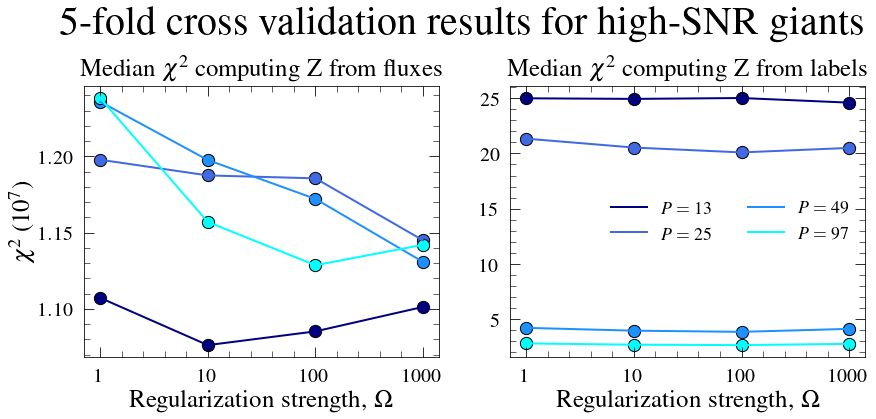

In [84]:
plt.figure(figsize=(14,5), facecolor='white', rasterized=True)

plt.suptitle('5-fold cross validation results for high-SNR giants', fontsize=40, y=1.1)
for indx, i in enumerate(c_median):

    plt.subplot(1,2,1)
    plt.title('Median $\chi^{2}$ computing Z from fluxes', fontsize=25, pad=10)
    plt.plot(regstrength[1:], i[1:]/1e7, label=nombres[indx], color = colores[indx], lw=2)
    plt.scatter(regstrength[1:], i[1:]/1e7, color = colores[indx], s=150, edgecolors='k')
    plt.ylabel('$\chi^{2}$ ($10^{7}$)', fontsize=25)
    # plt.ylim(0.6, )
    plt.xlabel('Regularization strength, $\Omega$', fontsize=25)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.subplot(1,2,2)
    plt.title('Median $\chi^{2}$ computing Z from labels', fontsize=25, pad=10)
    plt.plot(regstrength[1:], c_median_l[indx][1:]/1e7, label=nombres[indx], color = colores[indx], lw=2)
    plt.scatter(regstrength[1:], c_median_l[indx][1:]/1e7, color = colores[indx], s=150, edgecolors='k')
    plt.legend(loc='center right', frameon =False, fontsize=18, ncol=2)
    # plt.ylabel('$\chi^{2}$ ($10^{7}$)', fontsize=25)
    # plt.ylim(0.6, )
    plt.xlabel('Regularization strength, $\Omega$', fontsize=25)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

plt.savefig('../plots/paper/chi2_median_Kfold.pdf',dpi=200, bbox_inches = 'tight')
    

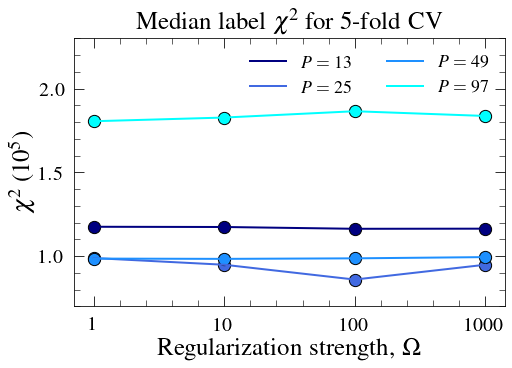

In [293]:
plt.figure(figsize=(7,5), constrained_layout=True, facecolor='white', rasterized=True)

for indx, i in enumerate(a_median):

    plt.title('Median label $\chi^{2}$ for 5-fold CV', fontsize=25, pad=10)
    plt.plot(regstrength[1:], i[1:]/1e5, label=nombres[indx], color = colores[indx], lw=2)
    plt.scatter(regstrength[1:], i[1:]/1e5, color = colores[indx], s=150, edgecolors='k')
    plt.legend(loc='upper right', frameon =False, fontsize=18, ncol=2)
    plt.ylabel('$\chi^{2}$ ($10^{5}$)', fontsize=25)
    plt.ylim(0.7,2.3)
    plt.xlabel('Regularization strength, $\Omega$', fontsize=25)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.savefig('../plots/paper/chi2_median_labels_Kfold.pdf',dpi=200, bbox_inches = 'tight')

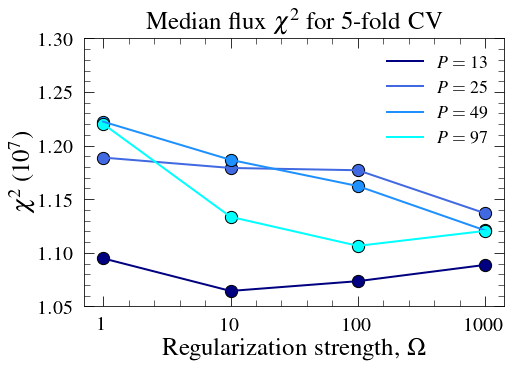

In [294]:
plt.figure(figsize=(7,5), constrained_layout=True, facecolor='white', rasterized=True)

for indx, i in enumerate(b_median):

    plt.title('Median flux $\chi^{2}$ for 5-fold CV', fontsize=25, pad=10)
    plt.plot(regstrength[1:], i[1:]/1e7, label=nombres[indx], color = colores[indx], lw=2)
    plt.scatter(regstrength[1:], i[1:]/1e7, color = colores[indx], s=150, edgecolors='k')
    plt.legend(loc='upper right', frameon =False, fontsize=18)
    plt.ylabel('$\chi^{2}$ ($10^{7}$)', fontsize=25)
    plt.ylim(1.05,1.3)
    plt.xlabel('Regularization strength, $\Omega$', fontsize=25)
    plt.tick_params(labelsize=25,direction='in',top=True,right=True,length=6,pad=10)
    plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
    plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
    plt.minorticks_on()

    plt.savefig('../plots/paper/chi2_median_fluxes_Kfold.pdf',dpi=200, bbox_inches = 'tight')

In [216]:
namesx = [1, 10, 100, 100]
namesy = [13, 25, 49, 97]
positionsx = [0, 1, 2, 3]
positionsy = [0, 1, 2, 3] 

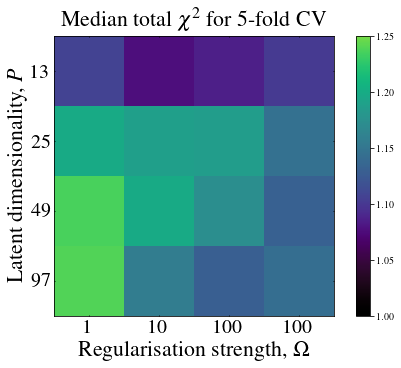

In [218]:
c_median_mat = c_median[:,1:]

plt.figure(figsize=(7,5), facecolor='white', rasterized=True, constrained_layout=True)
plt.title('Median total $\chi^{2}$ for 5-fold CV', fontsize=22, pad=10)
plt.imshow(c_median_mat/1e7, cmap=cm.lavender, vmin=1., vmax=1.25)
plt.colorbar()
plt.xticks(positionsx, namesx)
plt.yticks(positionsy, namesy)
plt.xlabel('Regularisation strength, $\Omega$', fontsize=22)
plt.ylabel('Latent dimensionality, $P$', fontsize=22)
plt.tick_params(labelsize=20,direction='in',top=True,right=True,length=1)


In [231]:
jnp.save(savepath+'percentiles_chi2_labels_kfold', a_per)
jnp.save(savepath+'percentiles_chi2_fluxes_kfold', b_per)
jnp.save(savepath+'percentiles_chi2_total_kfold', c_per)

jnp.save(savepath+'median_chi2_labels_kfold', a_median)
jnp.save(savepath+'median_chi2_fluxes_kfold', b_median)
jnp.save(savepath+'median_chi2_total_kfold', c_median)